In [1]:
import sys
from pyprojroot import here as project_root

sys.path.insert(0, str(project_root()))

from fs_mol.data.multitask import get_multitask_inference_batcher
from fs_mol.utils.torch_utils import torchify

from fs_mol.models.gnn_multitask import GNNMultitaskModel

from bayes_opt.bo_utils import load_covid_moonshot_dataset, run_gp_ei_bo, min_so_far, task_to_batches
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
task = load_covid_moonshot_dataset("covid-moonshot-dataset.csv", "../../fs_mol/preprocessing/utils/helper_files/")

Skipping datapoint O=C(C[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21)N1CCN(CCCO)CC1 (IC50 Fluorescence not available).
Skipping datapoint O=C(C[C@@]1(C(=O)Nc2cncc3ccccc23)CCOc2ccc(Cl)cc21)N1CCN(CC(F)(F)CO)CC1 (IC50 Fluorescence not available).
Skipping datapoint O=C(Nc1cncc2cnccc12)[C@H]1CCOc2ccc(Cl)cc21 (IC50 Fluorescence not available).
Skipping datapoint COc1cc(Cl)cc2c1OCC[C@@H]2C(=O)Nc1cncc2ccccc12 (IC50 Fluorescence not available).
Skipping datapoint COc1ccc2c(N)nn(C(=O)C3CCOc4ccc(Cl)cc43)c2c1 (IC50 Fluorescence not available).
Skipping datapoint O=C1CC(NC(=O)C2CCOc3ccc(Cl)cc32)CCN1 (IC50 Fluorescence not available).
Skipping datapoint COc1ccc2n[nH]c(NC(=O)C3CCOc4ccc(Cl)cc43)c2c1 (IC50 Fluorescence not available).
Skipping datapoint O=C(Nc1[nH]nc2cc(F)ccc12)C1CCOc2ccc(Cl)cc21 (IC50 Fluorescence not available).
Skipping datapoint O=C(Cc1cccc(Cl)c1)N[C@H]1CCNC1=O (IC50 Fluorescence not available).
Skipping datapoint Cc1ccncc1NC(=O)[C@@H](C)OC(F)F (IC50 Fluorescence not available).
S

In [3]:
batcher = get_multitask_inference_batcher(max_num_graphs=30, device=device)
gnnmt_batches = torchify(
    task_to_batches(task, batcher), 
    device=device
)

In [4]:
model_weights_file = "../../../fs-mol-checkpoints/multitask_best_model.pt"

gnnmt_model = GNNMultitaskModel.build_from_model_file(
    model_weights_file,
    device=device
).to(device)

gnnmt_model.eval()

GNNMultitaskModel(
  (criterion): BCEWithLogitsLoss()
  (graph_feature_extractor): GraphFeatureExtractor(
    (init_node_proj): Linear(in_features=32, out_features=128, bias=False)
    (gnn): GNN(
      (gnn_blocks): ModuleList(
        (0): GNNBlock(
          (mp_layers): ModuleList(
            (0): RelationalMultiAggrMP(
              (message_fns): ModuleList(
                (0): MLP(
                  (_layers): Sequential(
                    (0): Linear(in_features=64, out_features=192, bias=True)
                  )
                )
                (1): MLP(
                  (_layers): Sequential(
                    (0): Linear(in_features=64, out_features=192, bias=True)
                  )
                )
                (2): MLP(
                  (_layers): Sequential(
                    (0): Linear(in_features=64, out_features=192, bias=True)
                  )
                )
              )
            )
            (1): RelationalMultiAggrMP(
              (m

In [5]:
representations = []

for features in gnnmt_batches:
    with torch.no_grad():
        representation = gnnmt_model.graph_feature_extractor(features)
    representations.append(representation)
    
del gnnmt_model

In [6]:
dataset = task.samples

x_all = torch.cat(representations, dim=0)
y_all = torch.FloatTensor([float(x.numeric_label) for x in dataset]).to(device)

In [7]:
num_init_points = 16
query_batch_size = 1
num_bo_iters = 30
kernel_type = "matern"
init_from = 1200
noise_init = 0.01
noise_prior = True

num_repeats = 20

bo_records = []

In [8]:
for repeat in tqdm(range(num_repeats)):
    bo_record = run_gp_ei_bo(dataset, x_all, y_all, num_init_points, query_batch_size, num_bo_iters, kernel_type, device, init_from, noise_init, noise_prior)
    bo_records.append(min_so_far(bo_record))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [33:19<00:00, 99.97s/it]


(3.5, 9.0)

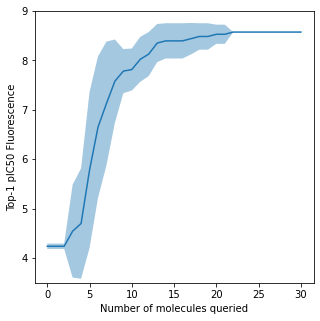

In [9]:
x_axis = np.arange(query_batch_size*num_bo_iters+1)

bo_records = np.array([[float(-1.0 * y_all[i].item()) for i in bo_record] for bo_record in bo_records])
bo_records_mean = bo_records.mean(axis=0)
bo_records_std = bo_records.std(axis=0)

plt.figure(figsize=(5,5))

plt.plot(x_axis, bo_records_mean)
plt.fill_between(x_axis, bo_records_mean-bo_records_std, bo_records_mean+bo_records_std, alpha=0.4)

plt.xlabel("Number of molecules queried")
plt.ylabel("Top-1 pIC50 Fluorescence")
plt.ylim(3.5, 9.0)

In [10]:
import pickle

with open("outputs/gnnmt_bo_records.pkl", "wb") as output_file:
    pickle.dump(bo_records, output_file)